Saved SVG: D:\DCM_manuscript_figure\pre_post\RGB\segment1_covariate1T.svg
Saved SVG: D:\DCM_manuscript_figure\pre_post\CMYK\segment1_covariate1T.svg
Saved SVG: D:\DCM_manuscript_figure\pre_post\Grayscale\segment1_covariate1T.svg
Saved SVG: D:\DCM_manuscript_figure\pre_post\RGB\segment1_covariate2T.svg
Saved SVG: D:\DCM_manuscript_figure\pre_post\CMYK\segment1_covariate2T.svg
Saved SVG: D:\DCM_manuscript_figure\pre_post\Grayscale\segment1_covariate2T.svg


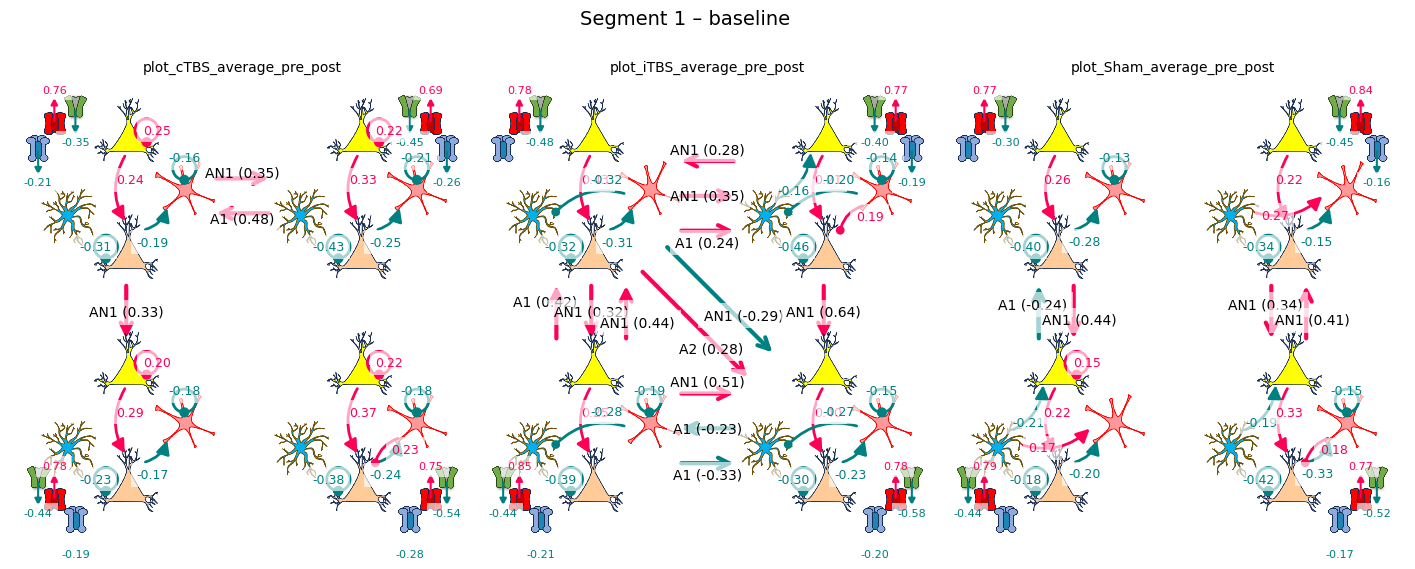

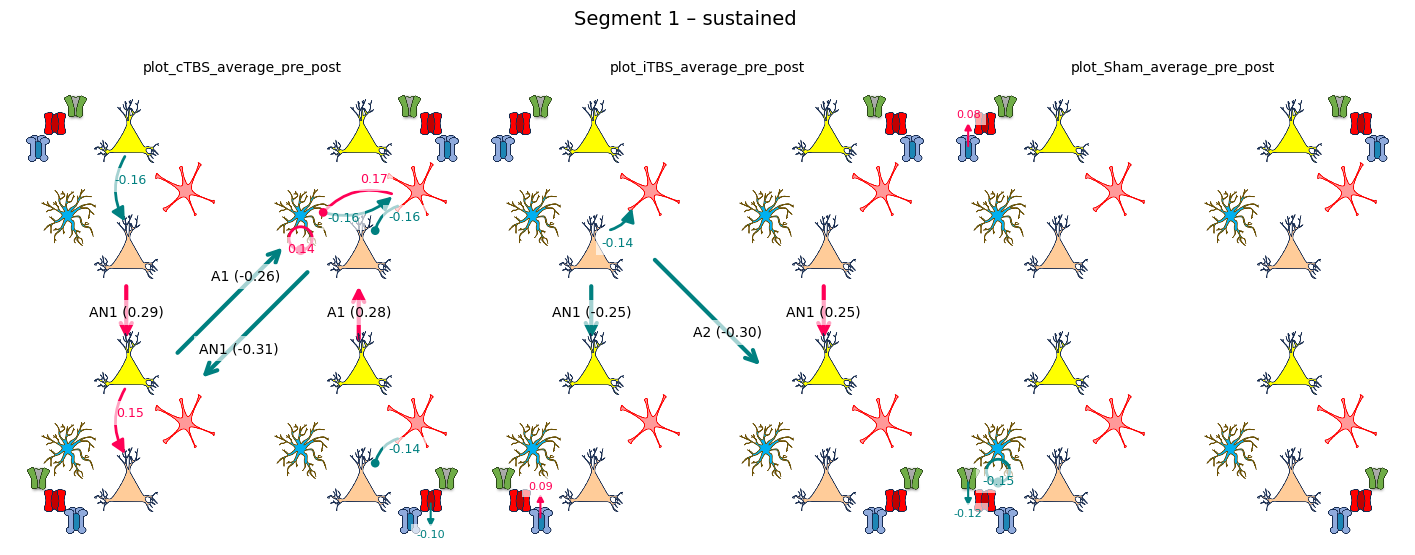

In [6]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.sparse import issparse
import networkx as nx
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.transforms import Bbox
from collections import defaultdict
import io
from PIL import Image

# =============================================================================
# Overview
# -----------------------------------------------------------------------------
# This script renders DCM connectivity schematics from MATLAB .mat outputs
# (Results.PEB_thresholded). It visualizes:
#   • Extrinsic connections (A/AN terms) between brain areas
#   • Intrinsic connections (H terms) within areas
#   • Ion-channel effects (T terms) drawn as per-area icons with up/down arrows
#
# For each input .mat file, the script:
#   1) Parses parameter names/values by segment and covariate
#   2) Lays out regions in a 2×2 grid
#   3) Draws extrinsic/intrinsic edges with label de-overlap logic
#   4) Places ion-channel icons on a ring around each area
#   5) Exports SVG/PNG-derived RGB/CMYK/Grayscale images
#
# Tuning knobs live in the constants section below (sizes, offsets, arrow styles).
# =============================================================================

# -------------------------------  
# Colors (sign encoding for edges/arrows) 
# -------------------------------  
POS_COLOR = '#FF0056'
NEG_COLOR = '#008080'

def fmt_trunc_str(x, ndigits=2):
    """
    Format a numeric value with fixed decimal places—without rounding side effects.
    E.g., 0.1234 → '0.12'; 2 → '2.00'
    """
    s = str(x)
    if "." in s:
        whole, frac = s.split(".", 1)
        frac = (frac + "0"*ndigits)[:ndigits]
        return f"{whole}.{frac}"
    else:
        return f"{s}.{'0'*ndigits}"

# -------------------------------  
# Tuning knobs (kept consistent with prior figure style) 
# -------------------------------  
ICON_ZOOM                = 0.3
SHAPE_ICON_ZOOM          = 0.13
SHAPE_ARROW_LENGTH       = 1.0
GRID_SPACING             = 8
REGION_RADIUS            = 3
BASE_OFFSET              = 1.2
LABEL_PADDING            = 0.4
PARALLEL_PADDING         = 0.3
VERTICAL_LABEL_PAD       = 0.9
SCALE_INTRINSIC          = 2
INTRINSIC_ARROW_PADDING  = 0.8
CIRCLE_HEAD_RADIUS       = 0.15
CIRCLE_POINTER_SIZE      = CIRCLE_HEAD_RADIUS * 2
FIG_WIDTH_PER            = 5
FIG_HEIGHT               = 6

# Extrinsic geometry & export behavior
EXTRINSIC_TRIM           = 0.0     # keep arrow length comparable to historical plots
VERTICAL_THRESH          = 0.10    # treat edges as vertical if |ux| < threshold
FILENAME_SUFFIX          = "T"     # appended to exported filenames

# Label backgrounds (for all text balloons)
LABEL_BG_COLOR   = 'white'
LABEL_BG_ALPHA   = 0.65
LABEL_EDGE_COLOR = 'none'

# Diagonals: nudge labels along the edge away from the central crossing
DIAGONAL_PAIRS   = {(1, 4), (2, 3)}
DIAG_LABEL_SHIFT = 0.18  # place label at 0.5 + shift along the edge (clamped)

# Ion-channel placement controls
ION_CHANNEL_Y_OFFSETS = {1: -0.12}     # per-shape vertical micro-adjust
ICON_RING_OFFSET   = 0.5               # radial ring offset beyond region radius
ICON_ANG_OFFSETS   = {1: 0.0, 2: 0.0, 3: 0.0}
ICON_RADIAL_OFFS   = {1: 0.0, 2: 0.0, 3: 0.0}
ION_PUSH_OUT       = False             # if True, auto-push icons outward on overlap

# Intrinsic label nudges (fine control for label locations)
SOURCE_LABEL_OFFSETS = {1:(0.0,0.0),2:(0.0,0.0),3:(0.0,0.0),4:(0.0,-0.5)}
TARGET_LABEL_OFFSETS = {1:(0.0,0.3),2:(0.0,0.0),3:(0.0,0.0),4:(0.5,-0.3)}
SELF_LABEL_OFFSETS   = {1:(0.0,0.0),2:(0.0,0.0),3:(0.0,0.0),4:(0.0,0.0)}

RAW_TITLE_MAP = {'covariate1':'baseline','covariate2':'sustained','covariate3':'transient'}

# -------------------------------
# Layout & assets (absolute paths expected)
# -------------------------------
region_positions = {1:(0,GRID_SPACING), 2:(GRID_SPACING,GRID_SPACING),
                    3:(0,0), 4:(GRID_SPACING,0)}
intrinsic_base_positions = {1:(-1,0.5),2:(0,2.0),3:(1,1.0),4:(0,0)}
cell_nodes = {1:'SS',2:'SP',3:'II',4:'DP'}
node_images = {
    1: r"D:\DCM_manuscript_figure\pics\Picture6.png",
    2: r"D:\DCM_manuscript_figure\pics\Picture5.png",
    3: r"D:\DCM_manuscript_figure\pics\Picture7.png",
    4: r"D:\DCM_manuscript_figure\pics\Picture8.png"
}
shape_images = {
    1: r"D:\DCM_manuscript_figure\pics\Picture10.png",
    2: r"D:\DCM_manuscript_figure\pics\Picture20.png",
    3: r"D:\DCM_manuscript_figure\pics\Picture30.png"
}

# -------------------------------
# Self-loop helper (circle + round head)
# -------------------------------
def draw_self_loop_with_circle(ax, position, loop_radius=0.4, color=NEG_COLOR, lw=2,
                               offset=(0,0), arrow_angle_deg=270, pointer_size=CIRCLE_POINTER_SIZE):
    cx, cy = position[0]+offset[0], position[1]+offset[1]
    loop = patches.Circle((cx,cy), loop_radius, edgecolor=color, facecolor='none', lw=lw, zorder=12)
    ax.add_patch(loop)
    angle = np.deg2rad(arrow_angle_deg)
    bx = cx+loop_radius*np.cos(angle)
    by = cy+loop_radius*np.sin(angle)
    head = patches.Circle((bx,by), pointer_size/2, edgecolor=color, facecolor=color, zorder=13)
    ax.add_patch(head)
    return loop, head

# ===========================
# Label overlap utilities (for non-vertical edges)
# ===========================
class TransformedBbox(Bbox):
    """Utility: transform a Bbox into a different coordinate system."""
    def __new__(cls, bbox, transform):
        pts = transform.transform(bbox.get_points())
        return Bbox.from_extents(pts[0,0], pts[0,1], pts[1,0], pts[1,1])

def _get_text_bbox_in_data(ax, text):
    """Get a text artist's bbox in data coordinates (robust to NaNs)."""
    fig = ax.figure
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()
    bb_disp = text.get_window_extent(renderer=renderer)
    bb_data = TransformedBbox(bb_disp, ax.transData.inverted())
    if not np.isfinite([bb_data.x0, bb_data.y0, bb_data.x1, bb_data.y1]).all():
        x, y = text.get_position()
        eps = 1e-6
        bb_data = Bbox.from_extents(x-eps, y-eps, x+eps, y+eps)
    return bb_data

def _overlap_amount(a: Bbox, b: Bbox, pad=0.0):
    """Return (dx, dy) overlap between two bboxes with optional padding."""
    ax0, ay0, ax1, ay1 = a.x0 - pad, a.y0 - pad, a.x1 + pad, a.y1 + pad
    bx0, by0, bx1, by1 = b.x0 - pad, b.y0 - pad, b.x1 + pad, b.y1 + pad
    overlap_x = min(ax1, bx1) - max(ax0, bx0)
    overlap_y = min(ay1, by1) - max(ay0, by0)
    if overlap_x <= 0 or overlap_y <= 0:
        return 0.0, 0.0
    return overlap_x, overlap_y

def resolve_text_overlaps_axis_fixed(ax, texts, fixed_texts=None, pad=0.15, step=0.08, max_iter=300):
    """
    Greedy axis-based nudge: iteratively separates 'texts' from each other
    and from 'fixed_texts' (which act as obstacles). Adjusts the later label
    in the colliding pair to minimize cascaded motion.
    """
    if not texts:
        return
    fixed_texts = fixed_texts or []
    for _ in range(max_iter):
        moved = False
        bboxes_mov = [_get_text_bbox_in_data(ax, t) for t in texts]
        bboxes_fix = [_get_text_bbox_in_data(ax, t) for t in fixed_texts] if fixed_texts else []
        for j in range(len(texts)):
            bj = bboxes_mov[j]
            for fb in bboxes_fix:
                dx, dy = _overlap_amount(bj, fb, pad=pad)
                if dx > 0 and dy > 0:
                    bxc = 0.5*(bj.x0 + bj.x1); byc = 0.5*(bj.y0 + bj.y1)
                    axc = 0.5*(fb.x0 + fb.x1); ayc = 0.5*(fb.y0 + fb.y1)
                    if dx <= dy:
                        direction = 1.0 if bxc >= axc else -1.0
                        xj, yj = texts[j].get_position()
                        texts[j].set_position((xj + direction*(dx + step), yj))
                    else:
                        direction = 1.0 if byc >= ayc else -1.0
                        xj, yj = texts[j].get_position()
                        texts[j].set_position((xj, yj + direction*(dy + step)))
                    moved = True
            for i in range(j):
                bi = bboxes_mov[i]
                dx, dy = _overlap_amount(bj, bi, pad=pad)
                if dx > 0 and dy > 0:
                    axc = 0.5*(bi.x0 + bi.x1); ayc = 0.5*(bi.y0 + bi.y1)
                    bxc = 0.5*(bj.x0 + bj.x1); byc = 0.5*(bj.y0 + bj.y1)
                    if dx <= dy:
                        direction = 1.0 if bxc >= axc else -1.0
                        xj, yj = texts[j].get_position()
                        texts[j].set_position((xj + direction*(dx + step), yj))
                    else:
                        direction = 1.0 if byc >= ayc else -1.0
                        xj, yj = texts[j].get_position()
                        texts[j].set_position((xj, yj + direction*(dy + step)))
                    moved = True
        if not moved:
            break

# ========= Ion-channel helpers =========
def compute_channel_xy(cx, cy, angle_deg, base_radius, y_nudge=0.0):
    """Polar placement helper for ion-channel icons on a ring around a region center."""
    x = cx + base_radius * np.cos(np.deg2rad(angle_deg))
    y = cy + base_radius * np.sin(np.deg2rad(angle_deg)) + y_nudge
    return x, y

def _get_artist_bbox_in_data(ax, artist):
    """Get the bbox of a generic artist in data coords (works with AnnotationBbox)."""
    fig = ax.figure
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()
    try:
        bb_disp = artist.get_window_extent(renderer=renderer)
        bb_data = TransformedBbox(bb_disp, ax.transData.inverted())
        if not np.isfinite([bb_data.x0, bb_data.y0, bb_data.x1, bb_data.y1]).all():
            raise ValueError
        return bb_data
    except Exception:
        try:
            x, y = artist.xy
        except Exception:
            try:
                x, y = artist.get_position()
            except Exception:
                x, y = (0.0, 0.0)
        eps = 1e-6
        return Bbox.from_extents(x-eps, y-eps, x+eps, y+eps)

def adjust_channel_neuron_overlaps(ax, channel_records_by_area, neuron_artists_by_area,
                                   pad=0.01, radial_step=0.25, max_iter=25):
    """
    Optional overlap resolver for ion-channel icons vs neuron icons.
    When ION_PUSH_OUT=True, iteratively pushes channel icons radially outward
    until overlaps are eliminated or max_iter is reached.
    """
    if not ION_PUSH_OUT:
        return
    fig = ax.figure
    for area, ch_list in channel_records_by_area.items():
        neur_list = neuron_artists_by_area.get(area, [])
        if not neur_list or not ch_list:
            continue
        for rec in ch_list:
            ang  = rec['angle_deg']
            r    = rec['radius']
            cx, cy = rec['center']
            yn    = rec['y_nudge']
            artist = rec['artist']
            for _ in range(max_iter):
                fig.canvas.draw()
                ch_bb = _get_artist_bbox_in_data(ax, artist)
                overlap_found = False
                for neur in neur_list:
                    neur_bb = _get_artist_bbox_in_data(ax, neur)
                    dx_need, dy_need = _overlap_amount(ch_bb, neur_bb, pad=pad)
                    if dx_need > 0 and dy_need > 0:
                        overlap_found = True
                        break
                if not overlap_found:
                    break
                r += radial_step
                x, y = compute_channel_xy(cx, cy, ang, r, yn)
                try:
                    artist.xy = (x, y)
                except Exception:
                    artist.set_xy((x, y))
                rec['radius'] = r

# -------------------------------  
# .mat reader: extract Ep/Pnames into segments/covariates
# -------------------------------
def process_file(mat_file_path):
    """
    Loads Results.PEB_thresholded and returns a list of segments (dicts).
      segment = {
        'cov_extrinsic':    {cov: [(src, tgt, label, Ep), ...], ...},
        'covariate_groups': {cov: [{'label': 'H(...)', 'Ep': val}, ...], ...},
        'cov_shape':        {cov: [(area, shape_idx, Ep), ...], ...},
        'cov_keys_all':     [all covariate keys seen in this segment],
        'segment':          1-based index
      }
    Works with:
      (A) old format: struct array [N x 1] with scalar Ep, string Pnames
      (B) new format: scalar struct with Ep [nSeg*nNames] (can be dense/sparse),
                      Pnames [nNames] (cellstr/char/object)
    """
    import re
    import numpy as np
    import scipy.io as sio
    from scipy.sparse import issparse

    pat_ex    = re.compile(r'(?i)\b(A|AN)\{(\d+)\}\(\s*(\d+)\s*,\s*(\d+)\s*\)')
    pat_shape = re.compile(r'(?i)^covariate\s+(\d+)\s*:\s*T\(\s*(\d+)\s*,\s*(\d+)(?:\s*,\s*\d+)?\s*\)$')

    def to_float(v):
        # robust scalar extractor: handles sparse, numpy scalars, 0-d arrays, python scalars
        try:
            if issparse(v):
                arr = v.toarray()
                return float(np.asarray(arr).squeeze())
        except Exception:
            pass
        try:
            return float(np.asarray(v).squeeze())
        except Exception:
            # last resort
            return float(v)

    def normalize_pnames(pnames_field):
        # unwrap nested 1x1 object arrays and cellstrs
        x = pnames_field
        while isinstance(x, np.ndarray) and x.dtype == object and x.size == 1:
            x = x.item()
        if isinstance(x, (list, tuple)):
            return [str(s).strip() for s in x]
        if isinstance(x, np.ndarray):
            if x.dtype == object:
                return [str(s).strip() for s in x.ravel()]
            # char/unicode array fallback
            return [str(s).strip() for s in x.ravel()]
        return [str(x).strip()]

    def flatten_numeric(vec_like):
        # vec_like can be dense ndarray, sparse matrix/array, or object array of scalars/sparses
        if issparse(vec_like):
            return np.asarray(vec_like.toarray(), dtype=float).ravel()
        try:
            return np.asarray(vec_like, dtype=float).ravel()
        except Exception:
            return np.array([to_float(x) for x in np.ravel(vec_like)], dtype=float)

    mat = sio.loadmat(mat_file_path, squeeze_me=True, struct_as_record=False)
    if 'Results' not in mat:
        raise KeyError(f"'Results' not found in {mat_file_path}")
    res = mat['Results']
    if not hasattr(res, 'PEB_thresholded'):
        raise KeyError(f"'Results.PEB_thresholded' not found in {mat_file_path}")
    peb = res.PEB_thresholded

    segments = []

    # ----- CASE B: scalar struct with vector fields -----
    if hasattr(peb, 'Ep') and hasattr(peb, 'Pnames'):
        Ep_vec = flatten_numeric(getattr(peb, 'Ep'))
        Pnames_block = normalize_pnames(getattr(peb, 'Pnames'))
        Np = len(Pnames_block)
        if Np == 0:
            raise ValueError("Pnames block is empty in PEB_thresholded.")

        nseg = (len(Ep_vec) // Np) if (len(Ep_vec) % Np == 0 and len(Ep_vec) >= Np) else 1

        for s in range(nseg):
            Ep_s = Ep_vec[s * Np:(s + 1) * Np] if nseg > 1 else Ep_vec

            cov_ex, cov_int, cov_shape = {}, {}, {}
            for i, pn in enumerate(Pnames_block):
                val = float(Ep_s[i])

                # Ion-channel T(...): keep even when val==0 to place icon
                m_sh = pat_shape.search(pn)
                if m_sh:
                    cov_idx, area, shape_idx = map(int, m_sh.groups())
                    key = f"Covariate {cov_idx}"
                    cov_shape.setdefault(key, []).append((area, shape_idx, val))

                # skip zeros for extrinsic/intrinsic only (clutter control)
                if val == 0:
                    continue

                # split "Covariate X: <connection label>"
                if ':' in pn:
                    parts = re.split(r'\s*:\s*', pn, maxsplit=1)
                    cov, conn = (parts[0].strip(), parts[1].strip()) if len(parts) == 2 else (pn, '')
                else:
                    cov, conn = pn, ''

                # Extrinsic A/AN{ins}(tgt,src)
                m_ex = pat_ex.search(conn)
                if m_ex:
                    typ, ins, tgt, src = m_ex.groups()
                    src_i, tgt_i = int(src), int(tgt)
                    cov_ex.setdefault(cov, []).append((src_i, tgt_i, f"{typ}{ins}", val))

                # Intrinsic H(...)
                if re.match(r'(?i)^covariate\s+\d+\b', cov) and conn.startswith('H'):
                    cov_int.setdefault(cov, []).append({"label": conn, "Ep": val})

            # collect all cov keys seen in this segment (for ordered_covs)
            cov_keys = set(cov_ex.keys()) | set(cov_int.keys()) | set(cov_shape.keys())
            cov_keys_all = sorted(
                cov_keys,
                key=lambda s: int(re.search(r'\d+', s).group()) if re.search(r'\d+', s) else 10**9
            )

            segments.append({
                'cov_extrinsic':    cov_ex,
                'covariate_groups': cov_int,
                'cov_shape':        cov_shape,
                'cov_keys_all':     cov_keys_all,
                'segment':          s + 1
            })
        return segments

    # ----- CASE A: struct array (old format) -----
    if isinstance(peb, np.ndarray):
        Ep_list, Pnames_list = [], []
        for elem in np.ravel(peb):
            Ep_list.append(to_float(getattr(elem, 'Ep')))
            Pnames_list.append(str(getattr(elem, 'Pnames')).strip())

        Ep = np.asarray(Ep_list, dtype=float)
        Pnames = list(Pnames_list)

        Np = len(Pnames)
        if Np == 0:
            raise ValueError("No parameter names found in PEB_thresholded.")
        nseg = len(Ep) // Np if len(Ep) % Np == 0 else 1

        for s in range(nseg):
            Ep_s = Ep[s * Np:(s + 1) * Np] if nseg > 1 else Ep

            cov_ex, cov_int, cov_shape = {}, {}, {}
            for i, pn in enumerate(Pnames):
                val = float(Ep_s[i])

                m_sh = pat_shape.search(pn)
                if m_sh:
                    cov_idx, area, shape_idx = map(int, m_sh.groups())
                    key = f"Covariate {cov_idx}"
                    cov_shape.setdefault(key, []).append((area, shape_idx, val))

                if val == 0:
                    continue

                if ':' in pn:
                    parts = re.split(r'\s*:\s*', pn, maxsplit=1)
                    cov, conn = (parts[0].strip(), parts[1].strip()) if len(parts) == 2 else (pn, '')
                else:
                    cov, conn = pn, ''

                m_ex = pat_ex.search(conn)
                if m_ex:
                    typ, ins, tgt, src = m_ex.groups()
                    src_i, tgt_i = int(src), int(tgt)
                    cov_ex.setdefault(cov, []).append((src_i, tgt_i, f"{typ}{ins}", val))

                if re.match(r'(?i)^covariate\s+\d+\b', cov) and conn.startswith('H'):
                    cov_int.setdefault(cov, []).append({"label": conn, "Ep": val})

            cov_keys = set(cov_ex.keys()) | set(cov_int.keys()) | set(cov_shape.keys())
            cov_keys_all = sorted(
                cov_keys,
                key=lambda s: int(re.search(r'\d+', s).group()) if re.search(r'\d+', s) else 10**9
            )

            segments.append({
                'cov_extrinsic':    cov_ex,
                'covariate_groups': cov_int,
                'cov_shape':        cov_shape,
                'cov_keys_all':     cov_keys_all,
                'segment':          s + 1
            })
        return segments

    raise TypeError("Unrecognized PEB_thresholded format.")

def plot_connectivity_for_covariate(ax, cov, data):
    """
    Core renderer for one covariate on a single Axes:
      • Regions: invisible circles for padding
      • Ion channels: icons arranged on a ring with up/down arrows
      • Extrinsic edges: multi-lane arrows with label disambiguation
      • Intrinsic edges: inside-area arrows + self-loops with labels
    """
    ax.set_aspect('equal','box'); ax.axis('off')

    # Region circles (invisible edge; defines layout padding)
    for pos in region_positions.values():
        ax.add_patch(patches.Circle(pos, REGION_RADIUS, facecolor='none', edgecolor='none', zorder=1))

    # ===== Ion channels (equal-angle placement on a fixed-radius ring) =====
    cov_shapes = data.get('cov_shape', {}).get(cov, [])
    shapes_by_area = defaultdict(list)
    for area, shape_idx, ep_val in cov_shapes:
        shapes_by_area[area].append((shape_idx, ep_val))

    base_angles = {1:135, 2:45, 3:225, 4:315}
    spread_deg  = 30

    channel_artists_by_area = defaultdict(list)
    neuron_artists_by_area  = defaultdict(list)  # populated later if ION_PUSH_OUT=True

    for area, items in shapes_by_area.items():
        items_sorted = sorted(items, key=lambda x: x[0])
        n = len(items_sorted)
        cx, cy = region_positions[area]

        if n > 1:
            angs = np.linspace(base_angles[area] - spread_deg/2,
                               base_angles[area] + spread_deg/2, n)
        else:
            angs = np.array([base_angles[area]])
        if area in (1,3):
            angs = angs[::-1]

        for (shape_idx, ep_val), ang in zip(items_sorted, angs):
            ang = ang + ICON_ANG_OFFSETS.get(shape_idx, 0.0)
            r   = REGION_RADIUS + ICON_RING_OFFSET + ICON_RADIAL_OFFS.get(shape_idx, 0.0)
            x0, y0 = compute_channel_xy(cx, cy, ang, r, ION_CHANNEL_Y_OFFSETS.get(shape_idx, 0.0))

            try:
                img_arr = plt.imread(shape_images[shape_idx])
                img_box = OffsetImage(img_arr, zoom=SHAPE_ICON_ZOOM)
                if ep_val == 0:
                    img_box.set_alpha(0.8)
                ab = AnnotationBbox(img_box, (x0, y0), frameon=False, zorder=5)
                ax.add_artist(ab)
                channel_artists_by_area[area].append({
                    'artist': ab, 'angle_deg': ang, 'radius': r,
                    'center': (cx, cy), 'y_nudge': ION_CHANNEL_Y_OFFSETS.get(shape_idx, 0.0),
                })
            except FileNotFoundError:
                sc = ax.scatter(x0, y0, s=100, color='gray', zorder=5)
                channel_artists_by_area[area].append({
                    'artist': sc, 'angle_deg': ang, 'radius': r,
                    'center': (cx, cy), 'y_nudge': ION_CHANNEL_Y_OFFSETS.get(shape_idx, 0.0),
                })

            if ep_val != 0:
                col = POS_COLOR if ep_val > 0 else NEG_COLOR
                dy  = SHAPE_ARROW_LENGTH if ep_val > 0 else -SHAPE_ARROW_LENGTH
                ax.annotate('', xy=(x0, y0+dy), xytext=(x0, y0),
                            arrowprops=dict(arrowstyle='-|>', color=col, lw=1.5), zorder=6)
                ax.text(x0, y0+dy, fmt_trunc_str(ep_val,2),
                        color=col, fontsize=8,
                        ha='center',
                        va='bottom' if ep_val>0 else 'top',
                        bbox=dict(facecolor=LABEL_BG_COLOR, alpha=LABEL_BG_ALPHA, edgecolor=LABEL_EDGE_COLOR),
                        zorder=6)

    # ===== Extrinsic edges (with lane-aware labels and overlap solver) =====
    cov_ex = data['cov_extrinsic'].get(cov, [])
    grouped_ex = {}
    for src, tgt, lab, ep in cov_ex:
        grouped_ex.setdefault(tuple(sorted((src, tgt))), []).append((src, tgt, lab, ep))

    nonvertical_texts = []
    vertical_texts    = []

    for undirected_pair, conns in grouped_ex.items():
        # Compute pair axis once (for label spacing on vertical pairs)
        src0, tgt0, _, _ = conns[0]
        P_src0 = np.array(region_positions[src0])
        P_tgt0 = np.array(region_positions[tgt0])
        vec_pair = P_tgt0 - P_src0
        L_pair = np.linalg.norm(vec_pair)
        if L_pair == 0:
            continue
        unit_pair = vec_pair / L_pair
        is_vertical_pair = abs(unit_pair[0]) < VERTICAL_THRESH

        # Canonical TOP->BOTTOM direction
        u_pair = -unit_pair if unit_pair[1] > 0 else unit_pair

        # Trimmed segment used to compute along-edge label coordinates
        trim = REGION_RADIUS + EXTRINSIC_TRIM
        pair_mid = (P_src0 + P_tgt0) / 2.0
        half_len = (L_pair - 2*trim) / 2.0
        if half_len < 0: half_len = 0
        start_base = pair_mid - u_pair * half_len
        end_base   = pair_mid + u_pair * half_len

        # Along-edge range (avoid hugging region boundaries)
        seg_len_pair = float(np.linalg.norm(end_base - start_base))
        t_margin = 0.45
        t_min = t_margin
        t_max = max(0.0, seg_len_pair - t_margin)

        if is_vertical_pair:
            k = len(conns)
            if k > 0 and t_max > t_min:
                segment = (t_max - t_min) / k
                t_positions = [t_min + (i + 0.5) * segment for i in range(k)]
            else:
                t_positions = [0.5 * (t_min + t_max)] * k

        for idx, (src, tgt, lab, ep) in enumerate(conns):
            base_idx = idx - (len(conns)-1)/2
            sign     = 1 if src < tgt else -1
            off_fac  = base_idx * sign

            P_src = np.array(region_positions[src])
            P_tgt = np.array(region_positions[tgt])
            vec = P_tgt - P_src
            L = np.linalg.norm(vec)
            unit = vec / L if L else np.zeros(2)
            perp = np.array([-unit[1], unit[0]])

            start = P_src + perp*BASE_OFFSET*off_fac + unit*(REGION_RADIUS + EXTRINSIC_TRIM)
            end   = P_tgt + perp*BASE_OFFSET*off_fac - unit*(REGION_RADIUS + EXTRINSIC_TRIM)

            color = POS_COLOR if ep>0 else NEG_COLOR
            ax.annotate('', xy=tuple(end), xytext=tuple(start),
                        arrowprops=dict(arrowstyle='->', lw=3, color=color, mutation_scale=20), zorder=3)

            if is_vertical_pair:
                # Lane-aware label placement with shared along-edge spacing
                t_i = t_positions[idx]
                base_point = start_base + u_pair * t_i
                lane_shift = (BASE_OFFSET + LABEL_PADDING) * off_fac
                lbl_pos = base_point + perp * lane_shift
                txt = ax.text(lbl_pos[0], lbl_pos[1],
                              f"{lab} ({fmt_trunc_str(ep, 2)})",
                              color='black', fontsize=10, ha='center', va='center',
                              bbox=dict(facecolor=LABEL_BG_COLOR, alpha=LABEL_BG_ALPHA, edgecolor=LABEL_EDGE_COLOR),
                              zorder=4)
                vertical_texts.append(txt)
            else:
                # Base mid placement with perpendicular/parallel nudges
                off_perp = perp * LABEL_PADDING * off_fac
                pad      = VERTICAL_LABEL_PAD if abs(unit[0]) < VERTICAL_THRESH else PARALLEL_PADDING
                off_para = unit * pad * base_idx if abs(unit[0]) < abs(unit[1]) else np.zeros(2)

                # Diagonals: push label toward target to avoid the crossing center
                if tuple(sorted((src, tgt))) in DIAGONAL_PAIRS:
                    edge_vec = end - start
                    L_eff    = float(np.linalg.norm(edge_vec))
                    if L_eff > 1e-9:
                        t_frac = min(0.95, max(0.05, 0.5 + DIAG_LABEL_SHIFT))
                        lbl_pos = start + unit * (L_eff * t_frac) + off_perp + off_para
                    else:
                        mid = (start + end)/2
                        lbl_pos = mid + off_perp + off_para
                else:
                    mid = (start + end)/2
                    lbl_pos = mid + off_perp + off_para

                txt = ax.text(lbl_pos[0], lbl_pos[1],
                              f"{lab} ({fmt_trunc_str(ep, 2)})",
                              color='black', fontsize=10, ha='center', va='center',
                              bbox=dict(facecolor=LABEL_BG_COLOR, alpha=LABEL_BG_ALPHA, edgecolor=LABEL_EDGE_COLOR),
                              zorder=4)
                nonvertical_texts.append(txt)

    # Resolve remaining label overlaps (verticals act as fixed obstacles)
    resolve_text_overlaps_axis_fixed(ax, texts=nonvertical_texts, fixed_texts=vertical_texts,
                                     pad=0.15, step=0.08, max_iter=300)

    # ===== Intrinsic edges + self-loops (within-area micrograph) =====
    cov_int = data['covariate_groups'].get(cov, [])
    for roi in region_positions:
        G = nx.MultiDiGraph()
        for n in cell_nodes: G.add_node(n)
        for ent in cov_int:
            if f",{roi})" in ent['label']:
                d,s,r = map(int, re.findall(r"\((\d+),(\d+),(\d+)\)", ent['label'])[0])
                if r==roi: G.add_edge(s,d,Ep=ent['Ep'])

        cent = np.mean(list(intrinsic_base_positions.values()), axis=0)
        pos = {n: tuple(np.array(region_positions[roi]) + SCALE_INTRINSIC*(np.array(p)-cent))
               for n,p in intrinsic_base_positions.items()}

        nonself,selfe = [],[]
        for u,v,d in G.edges(data=True):
            (selfe if u==v else nonself).append((u,v,d))

        grouped = {}
        for u,v,d in nonself:
            grouped.setdefault(tuple(sorted((u,v))), []).append((u,v,d))
        for edges in grouped.values():
            for i,(u,v,d) in enumerate(edges):
                rad = 0.3 + 0.05*(i-(len(edges)-1)/2)
                col = POS_COLOR if d['Ep']>0 else NEG_COLOR
                p0,p1 = np.array(pos[u]), np.array(pos[v])
                vec2, L2 = p1-p0, np.linalg.norm(p1-p0)
                if L2 > 2*INTRINSIC_ARROW_PADDING:
                    uv2 = vec2/L2
                    p0 += uv2*INTRINSIC_ARROW_PADDING
                    p1 -= uv2*INTRINSIC_ARROW_PADDING
                arrow = FancyArrowPatch(p0, p1,
                                        connectionstyle=f"arc3,rad={rad}",
                                        arrowstyle='-|>' if u!=3 else '-',
                                        mutation_scale=20,
                                        color=col, lw=2, zorder=12)
                ax.add_patch(arrow)
                if u==3:
                    ax.add_patch(patches.Circle(p1, CIRCLE_HEAD_RADIUS, facecolor=col, zorder=13))
                path = arrow.get_path().transformed(arrow.get_patch_transform())
                mp = path.interpolated(steps=100).vertices[50]
                offset = (np.array(SELF_LABEL_OFFSETS[u]) if u==v
                          else np.array(SOURCE_LABEL_OFFSETS.get(u,(0,0))) +
                               np.array(TARGET_LABEL_OFFSETS.get(v,(0,0))))
                mp += offset
                ax.text(mp[0], mp[1], fmt_trunc_str(d['Ep'],2),
                        color=col, fontsize=9,
                        ha='center', va='center',
                        bbox=dict(facecolor=LABEL_BG_COLOR, alpha=LABEL_BG_ALPHA, edgecolor=LABEL_EDGE_COLOR),
                        zorder=13)

        offsets = {1:(0,-0.7),2:(0.7,0),3:(0,0.7),4:(-0.7,0)}
        for u,_,d in selfe:
            p = pos[u]
            col = POS_COLOR if d['Ep']>0 else NEG_COLOR
            draw_self_loop_with_circle(ax, p, loop_radius=0.4, color=col, offset=offsets[u])
            lbl = (np.array([p[0]+offsets[u][0]*1.5, p[1]+offsets[u][1]*1.5]) +
                   np.array(SELF_LABEL_OFFSETS.get(u,(0,0))))
            ax.text(lbl[0], lbl[1], fmt_trunc_str(d['Ep'],2),
                    color=col, fontsize=9,
                    ha='center', va='center',
                    bbox=dict(facecolor=LABEL_BG_COLOR, alpha=LABEL_BG_ALPHA, edgecolor=LABEL_EDGE_COLOR),
                    zorder=14)

        # Neuron icons (stored for optional ion-channel push-out)
        for n,coord in pos.items():
            try:
                im = plt.imread(node_images[n])
                icon = OffsetImage(im, zoom=ICON_ZOOM)
                ab = AnnotationBbox(icon, coord, frameon=False)
                ax.add_artist(ab)
                neuron_artists_by_area[roi].append(ab)
            except FileNotFoundError:
                sc = ax.scatter(*coord, s=200, color='gray', zorder=10)
                neuron_artists_by_area[roi].append(sc)

    # Optional: separate ion-channel icons from neuron icons (radial push)
    adjust_channel_neuron_overlaps(ax, channel_records_by_area=channel_artists_by_area,
                                   neuron_artists_by_area=neuron_artists_by_area,
                                   pad=0.01, radial_step=0.25, max_iter=25)

    # Framing: expand limits to include icons and arrows
    xs = [p[0] for p in region_positions.values()]
    ys = [p[1] for p in region_positions.values()]
    pad = REGION_RADIUS + 1
    ax.set_xlim(min(xs)-pad, max(xs)+pad)
    ax.set_ylim(min(ys)-pad, max(ys)+pad)
    ax.margins(0.1)

def save_all_formats(fig, base_name, base_outdir, dpi=300):
    """
    Export helper. Saves to base_outdir/pre_post/{RGB,CMYK,Grayscale}:
      - base_name.svg (vector, transparent)
      - base_name.tiff (raster at `dpi`, LZW compression)
      - base_name.jpg (raster at `dpi`, quality=95)
    Raster outputs are rendered once to PNG (white background) and converted.
    """
    prepost_dir = os.path.join(base_outdir, 'pre_post')
    rgb_dir     = os.path.join(prepost_dir, 'RGB')
    cmyk_dir    = os.path.join(prepost_dir, 'CMYK')
    gray_dir    = os.path.join(prepost_dir, 'Grayscale')
    for d in (rgb_dir, cmyk_dir, gray_dir):
        os.makedirs(d, exist_ok=True)

    for d in (rgb_dir, cmyk_dir, gray_dir):
        svg_path = os.path.join(d, f"{base_name}.svg")
        fig.savefig(svg_path, format='svg', bbox_inches='tight', transparent=True)
        print(f"Saved SVG: {svg_path}")

    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=dpi, bbox_inches='tight',
                facecolor='white', edgecolor='white', transparent=False)
    buf.seek(0)
    rgb_im = Image.open(buf).convert('RGB')

    rgb_im.save(os.path.join(rgb_dir,  f"{base_name}.tiff"),
                format='TIFF', dpi=(dpi, dpi), compression='tiff_lzw')
    rgb_im.save(os.path.join(rgb_dir,  f"{base_name}.jpg"),
                format='JPEG', quality=95, dpi=(dpi, dpi), optimize=True)

    cmyk_im = rgb_im.convert('CMYK')
    cmyk_im.save(os.path.join(cmyk_dir, f"{base_name}.tiff"),
                 format='TIFF', dpi=(dpi, dpi), compression='tiff_lzw')
    cmyk_im.save(os.path.join(cmyk_dir, f"{base_name}.jpg"),
                 format='JPEG', quality=95, dpi=(dpi, dpi), optimize=True)

    gray_im = rgb_im.convert('L')
    gray_im.save(os.path.join(gray_dir, f"{base_name}.tiff"),
                 format='TIFF', dpi=(dpi, dpi), compression='tiff_lzw')
    gray_im.save(os.path.join(gray_dir, f"{base_name}.jpg"),
                 format='JPEG', quality=95, dpi=(dpi, dpi), optimize=True)

# -------------------------------  
# Main entry point
# -------------------------------
if __name__=='__main__':
    # Input: three averaged pre/post conditions. Adjust paths as needed.
    file_paths = [
        r'D:\DCM_manuscript_figure\plot_cTBS_average_pre_post.mat',
        r'D:\DCM_manuscript_figure\plot_iTBS_average_pre_post.mat',
        r'D:\DCM_manuscript_figure\plot_Sham_average_pre_post.mat'
    ]

    # Parse all files into segments/covariates
    all_segments = [process_file(fp) for fp in file_paths]

    # Union of all covariate keys present across segments/files
    covs = sorted(set().union(
        *[set(seg['cov_extrinsic'].keys()) |
          set(seg['covariate_groups'].keys()) |
          set(seg['cov_shape'].keys())
          for segs in all_segments for seg in segs]
    ))

    outdir = r'D:\DCM_manuscript_figure'
    os.makedirs(outdir, exist_ok=True)

    n_files = len(file_paths)
    n_segs  = len(all_segments[0])
    labels  = [os.path.splitext(os.path.basename(fp))[0] for fp in file_paths]

    # Render each segment × covariate in a row of subplots (one per file)
    for si in range(n_segs):
        for cov in covs:
            fig, axs = plt.subplots(1, n_files,
                                    figsize=(FIG_WIDTH_PER*n_files, FIG_HEIGHT),
                                    squeeze=False)
            axs = axs.flatten()
            fig.patch.set_facecolor('none')
            for ax in axs: ax.set_facecolor('none')

            for fi in range(n_files):
                plot_connectivity_for_covariate(axs[fi], cov, all_segments[fi][si])
                axs[fi].set_title(labels[fi], fontsize=10)

            key = cov.replace(' ','').lower()
            title = RAW_TITLE_MAP.get(key, cov)
            fig.suptitle(f"Segment {si+1} – {title}", fontsize=14)
            fig.subplots_adjust(left=0.05, right=0.98, top=0.9,
                                bottom=0.05, wspace=0)

            base_name = f"segment{si+1}_{key}{FILENAME_SUFFIX}"
            save_all_formats(fig, base_name, outdir, dpi=300)
